# Klaviyo Data Science Assessment

## Name : Ashwin Pillai
## Email : ashwin96@bu.edu

In [1]:
import pandas as pd
from functools import reduce
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


Read the data as a pandas dataframe. Convert the date column into datetime format.

In [2]:
data = pd.read_csv("screening_exercise_orders_v201810.csv")
data["date"] = pd.to_datetime(data.date)

Let us check the number of rows in the given data

In [3]:
len(data.index)

13471

Let us also check the number of rows in the given data when we get all unique customer ids from the table

In [4]:
len(data['customer_id'].unique())

8814

This means that we have multiple rows having duplicate customer ids. Let us see what the duplicate rows when sorted by the customer id looks like.

In [5]:
data[data.duplicated(subset=['customer_id'],keep=False)].sort_values('customer_id').head()

,customer_id,gender,date,value,predicted_gender
2,1002,1,2017-01-01 01:30:31,733.0,1
1742,1002,1,2017-02-19 21:35:31,176.0,1
928,1002,1,2017-01-23 04:33:38,148.6,1
3,1003,1,2017-01-01 01:34:22,772.0,1
4323,1003,1,2017-04-26 02:37:20,704.0,1


## PART A
    Assemble a dataframe with one row per customer and the following columns:
    * customer_id
    * gender
    * most_recent_order_date
    * order_count (number of orders placed by this customer)
    Sort the dataframe by customer_id ascending and display the first 10 rows.
  
  ## SOLUTION

Extraction of most recent order date per customer

In [6]:
data_sorted_by_date = data.sort_values("date", ascending=False)
data_groupby_customerid = data_sorted_by_date.groupby("customer_id")
data_series_orderdates_per_customer = data_groupby_customerid["date"].apply(list).apply(pd.Series).reset_index()
data_series_orderdates_per_customer = data_series_orderdates_per_customer[["customer_id", 0]]
data_series_orderdates_per_customer.columns = ["customer_id", "most_recent_order_date"]
data_series_orderdates_per_customer.head()

,customer_id,most_recent_order_date
0,1000,2017-01-01 00:11:31
1,1001,2017-01-01 00:29:56
2,1002,2017-02-19 21:35:31
3,1003,2017-04-26 02:37:20
4,1004,2017-01-01 03:11:54


Extraction of number of orders per customer

In [7]:
data_number_of_orders_per_customer = data_groupby_customerid[['customer_id']].size().reset_index()
data_number_of_orders_per_customer.columns = ['customer_id','order_count']
data_number_of_orders_per_customer.head()

,customer_id,order_count
0,1000,1
1,1001,1
2,1002,3
3,1003,4
4,1004,1


Extraction of gender per customer

In [8]:
data_gender_per_customer = data.groupby("customer_id")['gender'].apply(list).apply(pd.Series).reset_index()
data_gender_per_customer = data_gender_per_customer[['customer_id', 0]]
data_gender_per_customer.columns = ['customer_id','gender']
data_gender_per_customer.head()

,customer_id,gender
0,1000,0.0
1,1001,0.0
2,1002,1.0
3,1003,1.0
4,1004,0.0


Dataframe with one row per customer containing all columns as required

In [9]:
df_to_merge_list = [data_series_orderdates_per_customer, data_number_of_orders_per_customer, data_gender_per_customer]
df_final = reduce(lambda left,right: pd.merge(left,right,on='customer_id'), df_to_merge_list)

Dataframe sorted by "customer_id" in ascending order with 10 rows displayed

In [10]:
df_final.head(10)

,customer_id,most_recent_order_date,order_count,gender
0,1000,2017-01-01 00:11:31,1,0.0
1,1001,2017-01-01 00:29:56,1,0.0
2,1002,2017-02-19 21:35:31,3,1.0
3,1003,2017-04-26 02:37:20,4,1.0
4,1004,2017-01-01 03:11:54,1,0.0
5,1005,2017-12-16 01:39:27,2,1.0
6,1006,2017-05-09 15:27:20,3,1.0
7,1007,2017-01-01 15:59:50,1,0.0
8,1008,2017-12-17 05:47:48,3,0.0
9,1009,2017-01-01 19:27:17,1,1.0


## PART B
    Plot the count of orders per week.
  ## SOLUTION

Since we do not need time, we remove the time from the date and time provided in the "date" column 

**Assumption**: Weeks end on Saturday as per the calendar format. This is because the resample method returns data ordered by weeks with the 1st day in 2017 not as the part of the 1st week from 1st to 7th and outputs orders only for 1st and then from 2nd to 8th. So I had to hardcode the start of the week to consider the 1st week from 1st to 7th.

In [11]:
df_count_of_orders_per_week = pd.DataFrame()
df_count_of_orders_per_week['date_minus_time'] = data["date"].apply(lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
df_count_of_orders_per_week['ordersperday'] = 1
df_count_of_orders_per_week.set_index(df_count_of_orders_per_week["date_minus_time"],inplace=True)
result = df_count_of_orders_per_week['ordersperday'].resample('W-SAT').sum()

In [12]:
length_result = len(result)
weekcount = [week for week in range(1,length_result+1)]

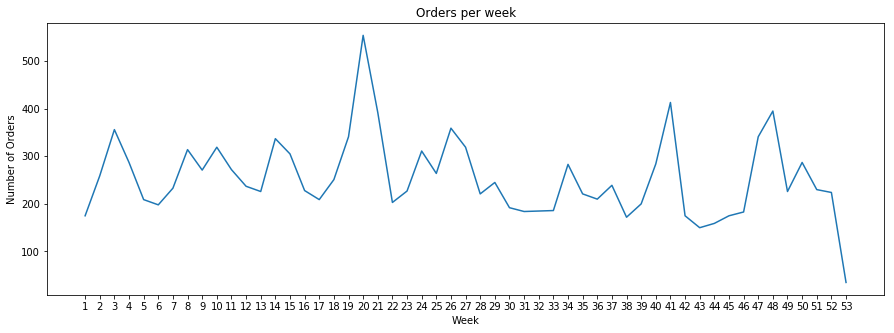

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Orders per week")
plt.xlabel("Week") # Text for X-Axis
plt.ylabel("Number of Orders") # Text for Y-Axis
plt.xticks(range(1, 54))
plt.plot(weekcount, result)


## PART C
    Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?
## SOLUTION

In [14]:
data_with_gender_0 = data.loc[data['gender'] == 0.0]["value"]
data_with_gender_1 = data.loc[data['gender'] == 1.0]["value"]

In [15]:
data_with_gender_0.describe()

count    6759.000000
mean      363.890006
std       396.533215
min         0.000000
25%       161.930000
50%       258.000000
75%       434.000000
max      8046.300000
Name: value, dtype: float64

In [16]:
data_with_gender_1.describe()

count    6712.000000
mean      350.708361
std       377.504737
min         0.000000
25%       161.200000
50%       258.000000
75%       416.000000
max      6877.000000
Name: value, dtype: float64

Variances for both samples

In [17]:
data_with_gender_0.var()

157238.590727079

In [18]:
data_with_gender_1.var()

142509.82682491024

In [19]:
count_order_value_for_gender_0 = data_with_gender_0.describe()[0]
mean_order_value_for_gender_0 = data_with_gender_0.describe()[1]
std_order_value_for_gender_0 = data_with_gender_0.describe()[2]

count_order_value_for_gender_1 = data_with_gender_1.describe()[0]
mean_order_value_for_gender_1 = data_with_gender_1.describe()[1]
std_order_value_for_gender_1 = data_with_gender_1.describe()[2]

### Significance testing for difference between mean order value for both genders

We can see that the samples are not paired in any ways and are independent of each other. Hence we can use a **Two sample t-test** to check for significance in the difference between the means of both samples.

**Assumption:** If we can safely make the assumption of the data in each group following a normal distribution, we can use a two-sample t-test to compare the means of random samples drawn from these two populations. If these assumptions are severely violated, the nonparametric Mann-Whitney U test, the randomization test, or the Kolmogorov-Smirnov test may be considered instead.

**Null hypothesis** : mean_order_value_for_gender_0 = mean_order_value_for_gender_1 <br>
**Significance level** = 0.01

In [20]:
# Calculation of t-test statistic
t = (mean_order_value_for_gender_0 - mean_order_value_for_gender_1)/(((std_order_value_for_gender_0**2/count_order_value_for_gender_0)+(std_order_value_for_gender_1**2/count_order_value_for_gender_1)))**0.5

t

1.976107933576866

In [21]:
degrees_of_freedom = min(count_order_value_for_gender_0, count_order_value_for_gender_1) - 1

degrees_of_freedom

6711.0

For **t = 1.976107933576866** and **df = 6711.0** the two tailed **p value = 0.0482** <br>
Since the p value is lesser than the significance level we can reject the null hypothesis and conclude that **the difference is statistically significant**.

## PART D
        
        Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted       gender. 
        What does the confusion matrix tell you about the quality of the predictions?
    
## SOLUTION

In [22]:
data_with_actual_and_predicted_gender = data[['customer_id', 'gender', 'predicted_gender']].groupby('customer_id').mean().reset_index()

In [23]:
data_with_actual_and_predicted_gender

,customer_id,gender,predicted_gender
0,1000,0,1
1,1001,0,1
2,1002,1,1
3,1003,1,1
4,1004,0,1
5,1005,1,0
6,1006,1,1
7,1007,0,0
8,1008,0,0
9,1009,1,1


Confusion Matrix: 
 [[2189 2218]
 [ 895 3512]]


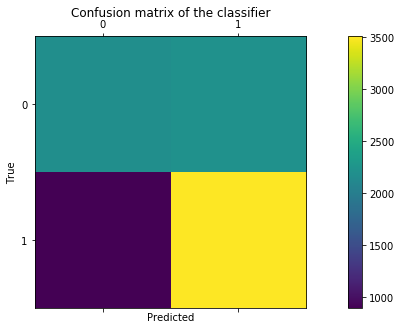

Accuracy:  0.6468118901747221 
F1-score:  0.6929071717470652 
Precision:  0.612914485165794 
Recall:  0.7969140004538234


In [24]:
actual_gender = pd.Series(data_with_actual_and_predicted_gender['gender'].values)
predicted_gender = pd.Series(data_with_actual_and_predicted_gender['predicted_gender'].values)
labels = ['0', '1']
cm = confusion_matrix(actual_gender, predicted_gender)
print("Confusion Matrix: \n",cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(actual_gender, predicted_gender)
f1score = f1_score(actual_gender, predicted_gender, average='binary')
precision = precision_score(actual_gender, predicted_gender, average='binary')
recall = recall_score(actual_gender, predicted_gender, average='binary')


print("Accuracy: ",accuracy, "\nF1-score: ",f1score, "\nPrecision: ",precision, "\nRecall: ",recall)


**Assumption** : In the confusion matrix we have assumed gender labelled '0' as positive and gender labelled '1' as negative

* The accuracy value is 0.6468 which shows that overall, the classifier is correct only 64.68% of the times.
* The classifier is wrong 35.31% of the times which is the misclassfication rate ((FP+FN)/total)
* The precision is 61.29% which gives us how often the classfier predicts positive (gender '0') correctly.
* The recall is intuitively the ability of the classifier to find all the positive samples given by the ratio (TP/(TP+FN)) and it is 79.69% here.
* A high recall and low precision here indicates that **most of the positive examples are correctly recognized (low FN) but there are a lot of false positives. Hence, Type I error is prevalent since the false positives are high.**





## PART E    
    Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a   problem. Limit your answer to one paragraph.

## SOLUTION

One of the tools that I am currently working with and which is one of my favorites is Apache Spark (PySpark). I am working on a Masters Thesis to predict the direction of movement of stock prices using financial news. While I was collecting data from 2014 to 2017, I had been using pandas for analysis. However, I gradually realized that the operations had been getting slower with added tasks of cleaning and feature engineering during the analysis because there were a few million news articles in the corpus. To deal with the problem scalably, I started using PySpark. It was really easy picking it up as I was already familar with Python and Pandas. It also provides the functionality of creating ML pipelines using MLLib which has a core set of machine learning algorithms. I also liked the recent Spark functionality with Pandas UDFs(User Defined Functions) that enable Python code to be executed in a distributed mode. Even though the components inside the Spark environment are at different levels of maturity, it is a great place to start with for implementing analytics use cases using batch processing.